<a href="https://colab.research.google.com/github/lavisrivastava/lab1/blob/main/image_dehazing_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!git clone https://github.com/zlinker/DehazeNet.git

Cloning into 'DehazeNet'...
remote: Enumerating objects: 18, done.
remote: Total 18 (delta 0), reused 0 (delta 0), pack-reused 18
Receiving objects: 100% (18/18), 635.57 KiB | 21.92 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [15]:
!pip install opencv-python



In [16]:
!apt-get install libprotobuf-dev libleveldb-dev libsnappy-dev libopencv-dev libhdf5-serial-dev protobuf-compiler
!pip install protobuf
!git clone https://github.com/BVLC/caffe.git
!cd caffe && pip install -r python/requirements.txt && cp Makefile.config.example Makefile.config
!cd caffe && make all -j8 && make pycaffe


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libhdf5-dev' instead of 'libhdf5-serial-dev'
libhdf5-dev is already the newest version (1.10.7+repack-4ubuntu2).
protobuf-compiler is already the newest version (3.12.4-1ubuntu7.22.04.1).
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
The following additional packages will be installed:
  libleveldb1d libprotobuf-lite23
Suggested packages:
  leveldb-doc
The following NEW packages will be installed:
  libleveldb-dev libleveldb1d libprotobuf-dev libprotobuf-lite23 libsnappy-dev
0 upgraded, 5 newly installed, 0 to remove and 32 not upgraded.
Need to get 1,892 kB of archives.
After this operation, 13.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleveldb1d amd64 1.23-3build1 [123 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleveldb-dev amd64 1.23-3build1 [183 kB]
Get:3 h

In [1]:
import sys
import caffe
import numpy as np
import cv2
import math

In [2]:
def EditFcnProto(templateFile, height, width):
	with open(templateFile, 'r') as ft:
		template = ft.read()
		outFile = 'DehazeNetFcn.prototxt'
		with open(outFile, 'w') as fd:
			fd.write(template.format(height_15=height+15, width_15=width+15,
				height_11=height+11, width_11=width+11))

In [3]:
def TransmissionEstimate(im_path, height, width):
	caffe.set_mode_cpu()
	net = caffe.Net('DehazeNet.prototxt', 'DehazeNet.caffemodel', caffe.TEST)
	net_full_conv = caffe.Net('DehazeNetFcn.prototxt', 'DehazeNet.caffemodel', caffe.TEST)
	net_full_conv.params['ip1-conv'][0].data.flat = net.params['ip1'][0].data.flat
	net_full_conv.params['ip1-conv'][1].data[...] = net.params['ip1'][1].data
	im = caffe.io.load_image(im_path)
	npad = ((7,8), (7,8), (0,0))
	im = np.pad(im, npad, 'symmetric')
	transformers = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
	transformers.set_transpose('data', (2,0,1))
	transformers.set_channel_swap('data', (2,1,0))
	out = net_full_conv.forward_all(data=np.array([transformers.preprocess('data', im-0.2)]))
	transmission = np.reshape(out['ip1-conv'], (height,width))
	return transmission

In [4]:
def DarkChannel(im,sz):
	b,g,r = cv2.split(im)
	dc = cv2.min(cv2.min(r,g),b)
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
	dark = cv2.erode(dc,kernel)
	return dark

In [5]:
def AtmLight(im,dark):
	[h,w] = im.shape[:2]
	imsz = h*w
	numpx = int(max(math.floor(imsz/1000),1))
	darkvec = dark.reshape(imsz,1)
	imvec = im.reshape(imsz,3)
	indices = darkvec.argsort()
	indices = indices[imsz-numpx::]
	atmsum = np.zeros([1,3])
	for ind in range(1,numpx):
		atmsum = atmsum + imvec[indices[ind]]
	A = atmsum / numpx
	return A

In [6]:
def Guidedfilter(im,p,r,eps):
	mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r))
	mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r))
	mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r))
	cov_Ip = mean_Ip - mean_I*mean_p
	mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r))
	var_I   = mean_II - mean_I*mean_I
	a = cov_Ip/(var_I + eps)
	b = mean_p - a*mean_I
	mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r))
	mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r))
	q = mean_a*im + mean_b
	return q


In [7]:
def TransmissionRefine(im,et):
	gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
	gray = np.float64(gray)/255
	r = 60
	eps = 0.0001
	t = Guidedfilter(gray,et,r,eps)
	return t

In [8]:
def Recover(im,t,A,tx = 0.1):
	res = np.empty(im.shape,im.dtype)
	t = cv2.max(t,tx)
	for ind in range(0,3):
		res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]
	return res

In [1]:
import os

if 'im_path' not in globals():
    print('The variable im_path is not defined. Please provide an image path as an argument.')
    exit()

The variable im_path is not defined. Please provide an image path as an argument.


In [1]:
import cv2
import sys

if __name__ == '__main__':
	if not len(sys.argv) == 2:
		print ('Usage: python DeHazeNet.py /content/62783.jpg')
		exit()
	else:
		im_path = sys.argv[1]
	src = cv2.imread(im_path)
	height = src.shape[0]
	width = src.shape[1]
	templateFile = 'DehazeFcnTemplate.prototxt'
	EditFcnProto(templateFile, height, width)
	I = src/255.0
	dark = DarkChannel(I,15)
	A = AtmLight(I,dark)
	te = TransmissionEstimate(im_path, height, width)
	t = TransmissionRefine(src,te)
	J = Recover(I,t,A,0.1)
	cv2.imshow('TransmissionEstimate',te)
	cv2.imshow('TransmissionRefine',t)
	cv2.imshow('Origin',src)
	cv2.imshow('Dehaze',J)
	cv2.waitKey(0)
	save_path = im_path[:-4]+'_Dehaze'+im_path[-4:len(im_path)]
	cv2.imwrite(save_path,J*255)

/content/62783.jpg


NameError: name 'im_path' is not defined

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def dehaze(image, omega=0.95, t0=0.1, guided_filter_radius=60, guided_filter_eps=1e-3):
    """
    Dehaze an image using the Dark Channel Prior method.

    Args:
    - image: Input hazy image (BGR format).
    - omega: Parameter for controlling the atmospheric light.
    - t0: Minimum transmission value to avoid division by zero.
    - guided_filter_radius: Radius parameter for the guided filter.
    - guided_filter_eps: Epsilon parameter for the guided filter.

    Returns:
    - Dehazed image (BGR format).
    """
    # Convert image to float
    image = image.astype(np.float64) / 255.0

    # Calculate the dark channel of the image
    dark_channel = np.min(image, axis=2)

    # Estimate atmospheric light
    top_percentile = int(image.size * (1 - omega))
    top_intensity = np.partition(dark_channel.flatten(), top_percentile)[-top_percentile:]
    atmospheric_light = np.max(top_intensity)

    # Calculate the transmission map
    transmission = 1 - omega * dark_channel / atmospheric_light
    transmission = np.maximum(transmission, t0)

    # Guided filter to refine the transmission map
    guided_filter = cv2.ximgproc.createGuidedFilter(image, guided_filter_radius, guided_filter_eps)
    refined_transmission = guided_filter.filter(transmission)

    # Calculate the dehazed image
    dehazed_image = np.zeros_like(image)
    for i in range(3):
        dehazed_image[:, :, i] = (image[:, :, i] - atmospheric_light) / refined_transmission + atmospheric_light

    # Clip the values to [0, 1]
    dehazed_image = np.clip(dehazed_image, 0, 1)

    # Convert back to uint8
    dehazed_image = (dehazed_image * 255).astype(np.uint8)

    return dehazed_image

# Load an example image (you can replace this with your own image path)
image_path = "/content/62783.jpg"
image = cv2.imread(image_path)

# Dehaze the image
dehazed_image = dehaze(image)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)), plt.title('Dehazed Image')
plt.show()


error: OpenCV(4.8.0) /io/opencv_contrib/modules/ximgproc/src/guided_filter.cpp:679: error: (-215:Assertion failed) (guide.depth() == CV_32F || guide.depth() == CV_8U || guide.depth() == CV_16U) && (guide.channels() <= 3) in function 'init'


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def dehaze(image, omega=0.95, t0=0.1, guided_filter_radius=60, guided_filter_eps=1e-3):
    """
    Dehaze an image using the Dark Channel Prior method.

    Args:
    - image: Input hazy image (BGR format).
    - omega: Parameter for controlling the atmospheric light.
    - t0: Minimum transmission value to avoid division by zero.
    - guided_filter_radius: Radius parameter for the guided filter.
    - guided_filter_eps: Epsilon parameter for the guided filter.

    Returns:
    - Dehazed image (BGR format).
    """
    # Convert image to float
    image = image.astype(np.float64) / 255.0

    # Calculate the dark channel of the image
    dark_channel = np.min(image, axis=2)

    # Estimate atmospheric light
    top_percentile = int(image.size * (1 - omega))
    top_intensity = np.partition(dark_channel.flatten(), top_percentile)[-top_percentile:]
    atmospheric_light = np.max(top_intensity)

    # Calculate the transmission map
    transmission = 1 - omega * dark_channel / atmospheric_light
    transmission = np.maximum(transmission, t0)

    # Convert the image to the required format for the guided filter
    guide_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

    # Guided filter to refine the transmission map
    guided_filter = cv2.ximgproc.createGuidedFilter(guide_image, guided_filter_radius, guided_filter_eps)
    refined_transmission = guided_filter.filter(transmission)

    # Calculate the dehazed image
    dehazed_image = np.zeros_like(image)
    for i in range(3):
        dehazed_image[:, :, i] = (image[:, :, i] - atmospheric_light) / refined_transmission + atmospheric_light

    # Clip the values to [0, 1]
    dehazed_image = np.clip(dehazed_image, 0, 1)

    # Convert back to uint8
    dehazed_image = (dehazed_image * 255).astype(np.uint8)

    return dehazed_image

# Load an example image (you can replace this with your own image path)
image_path = "/content/62783.jpg"
image = cv2.imread(image_path)

# Dehaze the image
dehazed_image = dehaze(image)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)), plt.title('Dehazed Image')
plt.show()


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def dehaze(image, omega=0.95, t0=0.1, guided_filter_radius=60, guided_filter_eps=1e-3):
    """
    Dehaze an image using the Dark Channel Prior method.

    Args:
    - image: Input hazy image (BGR format).
    - omega: Parameter for controlling the atmospheric light.
    - t0: Minimum transmission value to avoid division by zero.
    - guided_filter_radius: Radius parameter for the guided filter.
    - guided_filter_eps: Epsilon parameter for the guided filter.

    Returns:
    - Dehazed image (BGR format).
    """
    # Convert image to float
    image = image.astype(np.float64) / 255.0

    # Calculate the dark channel of the image
    dark_channel = np.min(image, axis=2)

    # Estimate atmospheric light
    top_percentile = int(image.size * (1 - omega))
    top_intensity = np.partition(dark_channel.flatten(), top_percentile)[-top_percentile:]
    atmospheric_light = np.max(top_intensity)

    # Calculate the transmission map
    transmission = 1 - omega * dark_channel / atmospheric_light
    transmission = np.maximum(transmission, t0)

    # Use one of the color channels as the guide image for the guided filter
    guide_image = image[:, :, 0]

    # Guided filter to refine the transmission map
    guided_filter = cv2.ximgproc.createGuidedFilter(guide_image, guided_filter_radius, guided_filter_eps)
    refined_transmission = guided_filter.filter(transmission)

    # Calculate the dehazed image
    dehazed_image = np.zeros_like(image)
    for i in range(3):
        dehazed_image[:, :, i] = (image[:, :, i] - atmospheric_light) / refined_transmission + atmospheric_light

    # Clip the values to [0, 1]
    dehazed_image = np.clip(dehazed_image, 0, 1)

    # Convert back to uint8
    dehazed_image = (dehazed_image * 255).astype(np.uint8)

    return dehazed_image

# Load an example image (you can replace this with your own image path)
image_path = "/content/62783.jpg"
image = cv2.imread(image_path)

# Dehaze the image
dehazed_image = dehaze(image)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)), plt.title('Dehazed Image')
plt.show()


error: OpenCV(4.8.0) /io/opencv_contrib/modules/ximgproc/src/guided_filter.cpp:679: error: (-215:Assertion failed) (guide.depth() == CV_32F || guide.depth() == CV_8U || guide.depth() == CV_16U) && (guide.channels() <= 3) in function 'init'


In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def dehaze(image, omega=0.95, t0=0.1, guided_filter_radius=60, guided_filter_eps=1e-3):
    """
    Dehaze an image using the Dark Channel Prior method.

    Args:
    - image: Input hazy image (BGR format).
    - omega: Parameter for controlling the atmospheric light.
    - t0: Minimum transmission value to avoid division by zero.
    - guided_filter_radius: Radius parameter for the guided filter.
    - guided_filter_eps: Epsilon parameter for the guided filter.

    Returns:
    - Dehazed image (BGR format).
    """
    # Convert image to float
    image = image.astype(np.float64) / 255.0

    # Calculate the dark channel of the image
    dark_channel = np.min(image, axis=2)

    # Estimate atmospheric light
    top_percentile = int(image.size * (1 - omega))
    top_intensity = np.partition(dark_channel.flatten(), top_percentile)[-top_percentile:]
    atmospheric_light = np.max(top_intensity)

    # Calculate the transmission map
    transmission = 1 - omega * dark_channel / atmospheric_light
    transmission = np.maximum(transmission, t0)

    # Use one of the color channels as the guide image for the guided filter
    guide_image = image[:, :, 0]

    # Guided filter to refine the transmission map
    refined_transmission = cv2.ximgproc.guidedFilter(guide_image, transmission, guided_filter_radius, guided_filter_eps)

    # Calculate the dehazed image
    dehazed_image = np.zeros_like(image)
    for i in range(3):
        dehazed_image[:, :, i] = (image[:, :, i] - atmospheric_light) / refined_transmission + atmospheric_light

    # Clip the values to [0, 1]
    dehazed_image = np.clip(dehazed_image, 0, 1)

    # Convert back to uint8
    dehazed_image = (dehazed_image * 255).astype(np.uint8)

    return dehazed_image

# Load an example image (you can replace this with your own image path)
image_path = "/content/62783.jpg"
image = cv2.imread(image_path)

# Dehaze the image
dehazed_image = dehaze(image)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)), plt.title('Dehazed Image')
plt.show()


error: OpenCV(4.8.0) /io/opencv_contrib/modules/ximgproc/src/guided_filter.cpp:679: error: (-215:Assertion failed) (guide.depth() == CV_32F || guide.depth() == CV_8U || guide.depth() == CV_16U) && (guide.channels() <= 3) in function 'init'


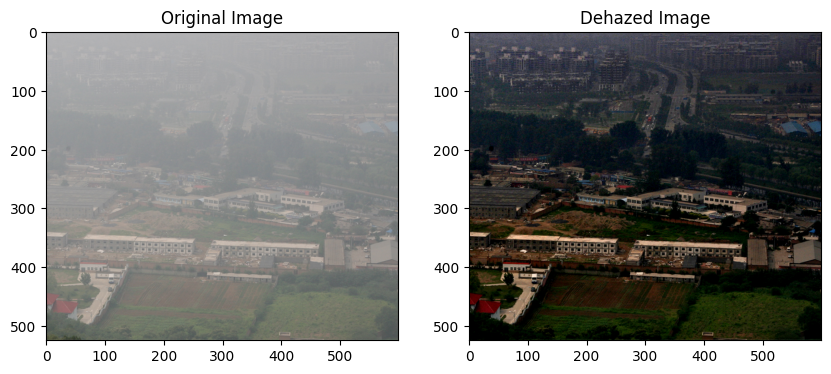

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def dehaze(image, omega=0.95, t0=0.1, guided_filter_radius=60, guided_filter_eps=1e-3):
    """
    Dehaze an image using the Dark Channel Prior method.

    Args:
    - image: Input hazy image (BGR format).
    - omega: Parameter for controlling the atmospheric light.
    - t0: Minimum transmission value to avoid division by zero.
    - guided_filter_radius: Radius parameter for the guided filter.
    - guided_filter_eps: Epsilon parameter for the guided filter.

    Returns:
    - Dehazed image (BGR format).
    """
    # Convert image to float
    image = image.astype(np.float64) / 255.0

    # Calculate the dark channel of the image
    dark_channel = np.min(image, axis=2)

    # Estimate atmospheric light
    top_percentile = int(image.size * (1 - omega))
    top_intensity = np.partition(dark_channel.flatten(), top_percentile)[-top_percentile:]
    atmospheric_light = np.max(top_intensity)

    # Calculate the transmission map
    transmission = 1 - omega * dark_channel / atmospheric_light
    transmission = np.maximum(transmission, t0)

    # Use one of the color channels as the guide image for the guided filter
    guide_image = image[:, :, 0].astype(np.float32) / 255.0

    # Convert transmission to the required format
    transmission = transmission.astype(np.float32)

    # Guided filter to refine the transmission map
    refined_transmission = cv2.ximgproc.guidedFilter(guide_image, transmission, guided_filter_radius, guided_filter_eps)

    # Calculate the dehazed image
    dehazed_image = np.zeros_like(image)
    for i in range(3):
        dehazed_image[:, :, i] = (image[:, :, i] - atmospheric_light) / refined_transmission + atmospheric_light

    # Clip the values to [0, 1]
    dehazed_image = np.clip(dehazed_image, 0, 1)

    # Convert back to uint8
    dehazed_image = (dehazed_image * 255).astype(np.uint8)

    return dehazed_image

# Load an example image (you can replace this with your own image path)
image_path = "/content/wwwwwwwwwwwwwwwww.jpg"
image = cv2.imread(image_path)

# Dehaze the image
dehazed_image = dehaze(image)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)), plt.title('Dehazed Image')
plt.show()


In [17]:
import cv2
from google.colab import files

# Save the dehazed image
output_path = "dehazed_image.jpg"
cv2.imwrite(output_path, cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB))

# Download the saved image
files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
import cv2

In [16]:
cv2.imshow("dehazed_image", dehazed_image)

DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow


In [9]:
cv2.imwrite("dehazed_image", dehazed_image)

error: OpenCV(4.8.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:696: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'
